In [1]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import database_credentials as dc

In [2]:
# Database credentials
postgres_user = dc.user()
postgres_pw = dc.pw()
postgres_host = dc.host()
postgres_port = dc.port()
postgres_db = dc.db()

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

# no need for an open connection,
# as we're only doing a single query
engine.dispose()

In [3]:
# Creating a table with all accepted offers in the last 28 days
sql = '''
SELECT carrier_name, carrier_type, status, carrier_guid, order_id, date(accepted_date) 
FROM stms_db2_shipper.offers
WHERE status IN ('paid', 'delivered', 'accepted', 'picked_up', 'invoiced')
AND accepted_date >= date(current_date - interval '28 days')
AND accepted_date < date(current_date)
'''
offers = pd.read_sql_query(sql, con=engine)
offers = offers.rename(columns={'date': 'accepted_date'})
offers

,carrier_name,carrier_type,status,carrier_guid,order_id,accepted_date
0,AMG FREIGHT,CTMS,paid,5b2bdd7b-37ef-420e-bb30-83ea62aa34a8,1063293,2020-12-24
1,SAFE-T-DRIVE TRUCKING LLC,CTMS,invoiced,3be92155-ea52-40b4-aef3-0521d381cbf3,1073116,2020-12-22
2,Robert Dean Transport LLC,CTMS,invoiced,85938415-9959-48b8-9675-86c5e3131ec2,1074865,2020-12-22
3,Suffy Transport,CTMS,paid,cdb6346e-1ba1-42a8-a9c3-e7bf2fb9a5d6,1073895,2020-12-22
4,ABSOLUTE CHAUFFEURED TRANSPORTATION LLC,CTMS,paid,04a69a7b-e8fc-495d-b91f-c66a2cfe86d8,1065954,2020-12-22
...,...,...,...,...,...,...
30091,WINDY TRANS LOGISTICS INC,CTMS,accepted,7e5a3d66-3400-43d5-9a7f-aa65ac56714d,1106452,2021-01-18
30092,D&W Trucking LLC,CTMS,accepted,ec13a230-75f0-46f2-a23d-552df378c648,1110091,2021-01-18
30093,DALE ADAMS,CTMS,accepted,f3f9e7cf-0799-4ab4-8f46-1488cc6ea037,1102588,2021-01-18
30094,JESUS ELIZONDO,CTMS,accepted,b727c45e-01a9-495f-9e4b-3b9a078e9568,1109220,2021-01-18


In [4]:
# Checking for missing values in every column
missing_values = offers.isna().sum()
missing_values

carrier_name     0
carrier_type     0
status           0
carrier_guid     3
order_id         0
accepted_date    0
dtype: int64

In [5]:
# Grouping the offers table to get the unique number of days a carrier accpeted an offer in last 28 days
unique_days_accepting_offer = offers.groupby(['carrier_name', 'carrier_guid'])[['accepted_date']].nunique()
unique_days_accepting_offer.reset_index(inplace=True)
unique_days_accepting_offer = unique_days_accepting_offer.rename(columns={'accepted_date': 'unique_days_accepting_offers'})
unique_days_accepting_offer

,carrier_name,carrier_guid,unique_days_accepting_offers
0,1 CALL AWAY,d8eeb04e-1f61-4855-9d8c-9fe364dc8044,8
1,1 DAY AUTO TRANSPORT LLC,e7099505-fd84-4b33-b516-619c3dba082b,1
2,10 WEST TRANSPORT LLC,8c18182c-23f2-4179-b65f-3cbd3ac27923,2
3,1ST CHOICE TRANSPORT,9cce6727-adef-40e3-95d7-0b5bfe237ec9,1
4,1ST SHOT TRUCKING LLC,fe1298ef-eb41-4557-a1ef-b266e557ac84,2
...,...,...,...
2975,eco transport,17e62317-e67d-4394-97cb-fcb319d471c3,1
2976,mj parker,13de9609-5f96-43cd-a15e-0765a91613ad,1
2977,peker transportation,8a82a6e7-f15b-4b74-8f23-a09f09d8c93d,1
2978,ref ref,81cc99a5-083b-4346-a369-71ef0efa5e2f,2


# now we need to get number of activated drivers for each carrier

In [6]:
# Creating a table with all drivers
sql = '''
SELECT genericuser_ptr_id, carrier_id, guid
FROM ctms_db_public.msd_driver
WHERE is_suspended = False
'''
drivers = pd.read_sql_query(sql, con=engine)
drivers = drivers.rename(columns={'guid': 'driver_guid'})
drivers

,genericuser_ptr_id,carrier_id,driver_guid
0,38,20,c03bbd2c-bcf4-43bc-ac35-1a622cdf34f4
1,84,28,5e0349d6-6720-467b-b72d-f248e1be6c4d
2,101,42,bb8229f1-0cb5-46ac-8db8-05ebdb1561f0
3,117,5478,81fe5f04-ff57-4f09-b99b-86b4fab06347
4,136,5478,f65c4afc-6d34-4d74-9a0f-e7323ab305df
...,...,...,...
62973,84359,40915,a2ce78c9-52b3-48fe-91f4-5d2cd1b0a5d1
62974,84679,40996,3ef37760-55e5-43da-8d2c-c461f3ad1a41
62975,84960,37928,381eef52-a634-44f6-93f7-35a85f75ea74
62976,85358,2305,2c220ce5-1228-427f-8fde-b3e7c3ffd02e


In [7]:
# The driver table needs carrier_guid. 
# I need the carrier table to join carrier_guid on the driver table
sql = '''
SELECT name, id, guid
FROM ctms_db_public.msd_carrier
WHERE test_account = False
'''
carriers = pd.read_sql_query(sql, con=engine)
carriers = carriers.rename(columns={'id': 'carrier_id', 'guid': 'carrier_guid'})
carriers

,name,carrier_id,carrier_guid
0,ON DEMAND AUTO TRANSPORT,20,711f7501-69f4-4828-9b78-118db0d15ed9
1,Jeffries Transport Services,49,c1d94c53-2803-4fe5-b9c9-8df3a0a58670
2,LDR Transportation LLC,53,8a66ee87-0924-46ff-a6fc-f8a5b264849d
3,continental,61,4c4d7a1b-fb38-43e1-8732-d382c96780ee
4,"C&D Transportation, Inc (duplicate)",70,7c8ee0e9-eaa3-4720-8bba-7c4982075119
...,...,...,...
40891,SMITH AUTO TRANSPORT,32770,e2ddafd8-c53b-463e-ba0c-106056aa9eaa
40892,TRUCKIT365 LLC,37205,a1671f0e-302c-42e8-a2cf-2fd42ba84740
40893,SUNSPHERE TRANSPORTATION AND LOGISTICS LLC,40324,5bd114f6-85af-4ced-9da4-5896ac9a3be0
40894,CARMEN & BUTCH TRUCKING COMPANY LLC,44517,3277653c-25fc-4420-bf9b-9f71d7078026


In [8]:
# Joining carrier_guid on driver table
drivers = drivers.merge(carriers, left_on='carrier_id', right_on='carrier_id')
drivers

,genericuser_ptr_id,carrier_id,driver_guid,name,carrier_guid
0,38,20,c03bbd2c-bcf4-43bc-ac35-1a622cdf34f4,ON DEMAND AUTO TRANSPORT,711f7501-69f4-4828-9b78-118db0d15ed9
1,219,20,92db1d6c-f2ba-4fd9-b59d-f590fa17863f,ON DEMAND AUTO TRANSPORT,711f7501-69f4-4828-9b78-118db0d15ed9
2,6698,20,850ea758-e571-4401-974d-af97e562c378,ON DEMAND AUTO TRANSPORT,711f7501-69f4-4828-9b78-118db0d15ed9
3,84,28,5e0349d6-6720-467b-b72d-f248e1be6c4d,Rum Runners Auto Transport,ad6b963f-0a4a-4b71-b643-eed8e713afce
4,101,42,bb8229f1-0cb5-46ac-8db8-05ebdb1561f0,Alt & Son Corp.,2271da16-eca1-48d6-8b67-9eeecdd6bd14
...,...,...,...,...,...
62226,76832,41083,e6a63309-dc3e-415e-bea6-610ab0127131,MACIAS & MACIAS TRANSPORT LLC,65cf2d41-29a2-4489-b5ee-8fe908697152
62227,79531,42039,c12bfb9c-a383-433d-98e3-79bd4b0a315c,MJ DELIVERIES,dbf463f4-287c-4107-8a73-165cd92e912a
62228,80344,42354,c56be0c9-00bb-4cfc-8c69-e830171c0e0f,HYPER EXPRESS LLC,168fdd4d-2b86-41f9-ba57-e9b65e2c7beb
62229,84776,44078,fa2bfa7d-4d78-4c0b-ab54-da4817be1c4e,FRANKY TRANSPORTATION,569e01f3-1337-4578-ab5c-41b7ea1ab274


In [9]:
# getting the unique number of drivers for each carrier
active_driver_count = drivers.groupby(['carrier_guid', 'carrier_id'])[['genericuser_ptr_id']].nunique()
active_driver_count.reset_index(inplace=True)
active_driver_count = active_driver_count.rename(columns={'genericuser_ptr_id': 'activated_drivers'})
active_driver_count

,carrier_guid,carrier_id,activated_drivers
0,000243e7-afae-455a-8e61-5c691916f39e,31952,1
1,0004758e-daf4-4d3f-8257-be49db385d8e,1198,1
2,000acb9e-e4bb-4cff-a5b3-3bedcf05babf,29808,1
3,000b7030-5bfc-4c95-8627-df29412347ff,43133,1
4,000b8e63-986b-4bae-befe-22481e2bfc9c,32277,1
...,...,...,...
38482,fff8e9ba-cbcd-4bf7-8f92-b00fba5ba543,9501,1
38483,fffa8e6a-3943-47f5-bc00-52f59d9cd0c6,28014,1
38484,fffb578c-7297-4ade-996d-eef9aed6c22c,9916,1
38485,ffff3737-7524-40a4-b225-a8832c96bf91,6038,1


In [10]:
big_carriers = active_driver_count[active_driver_count['activated_drivers'] > 1]
big_carriers

,carrier_guid,carrier_id,activated_drivers
8,00101b1d-cec9-4ef3-a89b-c81fb70c57e7,34807,5
14,0014e2ac-b1e2-4362-afc5-e11d0b43e66b,31220,3
20,002122c7-a59d-4902-b4d3-a1a06d8df65b,39039,3
24,0022f67f-f31c-4caa-a0dd-641038974c99,34022,2
28,0029175c-e577-4733-add3-4dce7462e7a4,24669,13
...,...,...,...
38454,ffcdcab1-8cf1-4174-8937-155727166847,37613,3
38457,ffcf6d68-f4dd-4188-8cea-d64b4cf31485,24841,3
38465,ffe03115-0de0-4506-b7ba-76f8a720031d,23092,2
38467,ffe4e97f-c8e0-4f07-8ddd-9bd0db249c2a,26738,5


In [11]:
result = unique_days_accepting_offer.merge(big_carriers, left_on='carrier_guid', right_on='carrier_guid')
result

,carrier_name,carrier_guid,unique_days_accepting_offers,carrier_id,activated_drivers
0,1 CALL AWAY,d8eeb04e-1f61-4855-9d8c-9fe364dc8044,8,7516,5
1,1ST SHOT TRUCKING LLC,fe1298ef-eb41-4557-a1ef-b266e557ac84,2,25023,9
2,20 TON CONSTRUCTION LLC,321d9b2c-0b00-41de-9236-e294034610db,1,33642,4
3,24 HOUR AUTO TRANSPORT INC,ef52a80c-4eae-4321-b69e-6e47c279ca30,3,24469,3
4,247 Trucking LLC,958a057d-de3c-4f4d-974b-a5c0675ae025,1,5873,6
...,...,...,...,...,...
1444,d&b transports,4da5ea50-b300-44ba-9424-eb50c54b382e,5,8409,2
1445,dealers choice auto transport,67e2cef2-bd46-476e-b96a-42190b835dd0,22,1682,27
1446,doyles transportation,6b8d9c0c-d639-4a17-be36-90f37b0e33a9,1,999,2
1447,eco transport,17e62317-e67d-4394-97cb-fcb319d471c3,1,18271,3


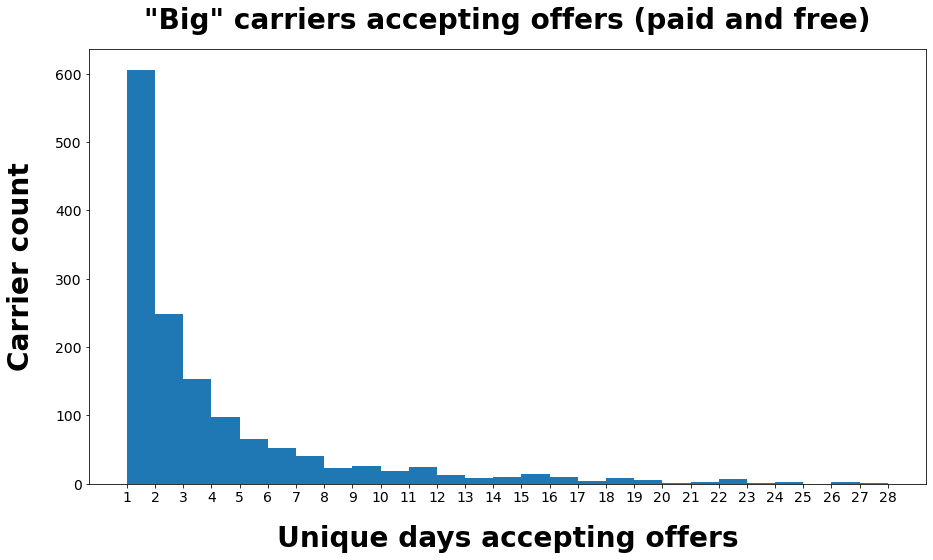

In [12]:
# histogram of unique accepted offers in last 28 days (paid and free users)
plt.figure(figsize=(15,8))
plt.hist(result['unique_days_accepting_offers'], bins=np.arange(1, 29))
plt.xticks(np.arange(1, 29), fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Unique days accepting offers', fontsize=28, fontweight='bold', labelpad=20)
plt.ylabel('Carrier count', fontsize=28, fontweight='bold', labelpad=20)
plt.title('"Big" carriers accepting offers (paid and free)', fontsize=28, fontweight='bold', pad=20)
plt.show()

# Now let's segment paid users and free users

In [13]:
# creating a table for braintree subscriptions
sql = '''
DROP TABLE IF EXISTS #carrier_with_latest_sub_date
;
SELECT 
carrier_id
,max(created_at) AS last_sub
INTO #carrier_with_latest_sub_date
FROM ctms_db_public.billing_braintreesubscription
WHERE braintree_subscription_status IN ('Active', 'Past Due', 'Pending')
GROUP BY carrier_id
;
SELECT 
#carrier_with_latest_sub_date.carrier_id
,last_sub
,braintree_subscription_status
FROM #carrier_with_latest_sub_date
JOIN ctms_db_public.billing_braintreesubscription
ON #carrier_with_latest_sub_date.carrier_id = billing_braintreesubscription.carrier_id
AND #carrier_with_latest_sub_date.last_sub = billing_braintreesubscription.created_at
WHERE billing_braintreesubscription.braintree_subscription_status IN ('Active', 'Past Due', 'Pending')
;
'''
braintree_subs = pd.read_sql_query(sql, con=engine)
braintree_subs

,carrier_id,last_sub,braintree_subscription_status
0,5466,2016-11-26 09:21:35.868856,Active
1,3298,2016-11-26 09:21:30.983747,Active
2,4925,2017-01-20 15:19:46.097090,Active
3,1421,2017-05-18 13:42:02.182933,Active
4,433,2017-06-19 19:32:44.584252,Active
...,...,...,...
2866,4116,2021-01-18 20:57:54.743970,Active
2867,41286,2020-11-05 22:06:52.942985,Active
2868,36837,2021-01-18 20:43:32.137428,Active
2869,5659,2021-01-18 21:08:43.603265,Active


In [14]:
# joining carriers with braintree table
braintree_with_carriers = braintree_subs.merge(carriers[['carrier_id', 'carrier_guid']],
                                               left_on='carrier_id', right_on='carrier_id')
braintree_with_carriers

,carrier_id,last_sub,braintree_subscription_status,carrier_guid
0,5466,2016-11-26 09:21:35.868856,Active,101ce8ba-b529-43c1-80bf-c0f6939ba2a3
1,3298,2016-11-26 09:21:30.983747,Active,7196d66a-cd25-4ae4-bcdb-15f01b895c2e
2,4925,2017-01-20 15:19:46.097090,Active,533c4db9-1f0e-4da2-83e1-ed1385508496
3,1421,2017-05-18 13:42:02.182933,Active,4ba23995-f6ad-4efa-86f8-e3d14d4d9e32
4,433,2017-06-19 19:32:44.584252,Active,525f3fe2-61bf-452b-b5dd-2ff269a05231
...,...,...,...,...
2866,4116,2021-01-18 20:57:54.743970,Active,ac64fd07-9018-4be7-9c81-fef79f47fbb6
2867,41286,2020-11-05 22:06:52.942985,Active,449569cb-5171-4351-8e9c-25ad36f196e6
2868,36837,2021-01-18 20:43:32.137428,Active,ef227962-d8f0-4a6f-a60f-b9d97c58ceec
2869,5659,2021-01-18 21:08:43.603265,Active,a1ef241d-81d3-47c0-91ec-2ce30e79642a


# Paid Users

In [15]:
result

,carrier_name,carrier_guid,unique_days_accepting_offers,carrier_id,activated_drivers
0,1 CALL AWAY,d8eeb04e-1f61-4855-9d8c-9fe364dc8044,8,7516,5
1,1ST SHOT TRUCKING LLC,fe1298ef-eb41-4557-a1ef-b266e557ac84,2,25023,9
2,20 TON CONSTRUCTION LLC,321d9b2c-0b00-41de-9236-e294034610db,1,33642,4
3,24 HOUR AUTO TRANSPORT INC,ef52a80c-4eae-4321-b69e-6e47c279ca30,3,24469,3
4,247 Trucking LLC,958a057d-de3c-4f4d-974b-a5c0675ae025,1,5873,6
...,...,...,...,...,...
1444,d&b transports,4da5ea50-b300-44ba-9424-eb50c54b382e,5,8409,2
1445,dealers choice auto transport,67e2cef2-bd46-476e-b96a-42190b835dd0,22,1682,27
1446,doyles transportation,6b8d9c0c-d639-4a17-be36-90f37b0e33a9,1,999,2
1447,eco transport,17e62317-e67d-4394-97cb-fcb319d471c3,1,18271,3


In [16]:
result_paid_users = (result.merge(braintree_with_carriers, left_on='carrier_guid',
                                           right_on='carrier_guid'))

result_paid_users = result_paid_users[['carrier_name', 'carrier_guid', 'unique_days_accepting_offers',
                                       'activated_drivers']]
result_paid_users['paid_user'] = True
result_paid_users

,carrier_name,carrier_guid,unique_days_accepting_offers,activated_drivers,paid_user
0,247 Trucking LLC,958a057d-de3c-4f4d-974b-a5c0675ae025,1,6,True
1,24KTRANSPORT LLC,309173d0-acf4-41d7-a050-818367ed6d80,19,2,True
2,2517 INC,2d596f76-0137-4a06-b14b-556bad55f2e4,10,40,True
3,2X TRANSPORTATION LLC,bcbd3c6d-04a8-457e-bec2-0a75c118f62a,5,2,True
4,3-LR TRANSPORT LLC,7af5a893-aaf0-49fb-81cf-f7792275b10c,1,2,True
...,...,...,...,...,...
479,Xtreme Transports,6c0d5a29-c651-4aa0-b5f9-6964451a2389,2,2,True
480,Y&R TRANSPORT INC,dba4e9ee-b84c-47d9-b284-6c3eef7fe923,1,4,True
481,YR AUTO SALES LLC,ef227962-d8f0-4a6f-a60f-b9d97c58ceec,7,21,True
482,"Z Brothers Expedited, LLC",ce1e4068-12e8-469b-be20-2de526d0dbe6,4,24,True


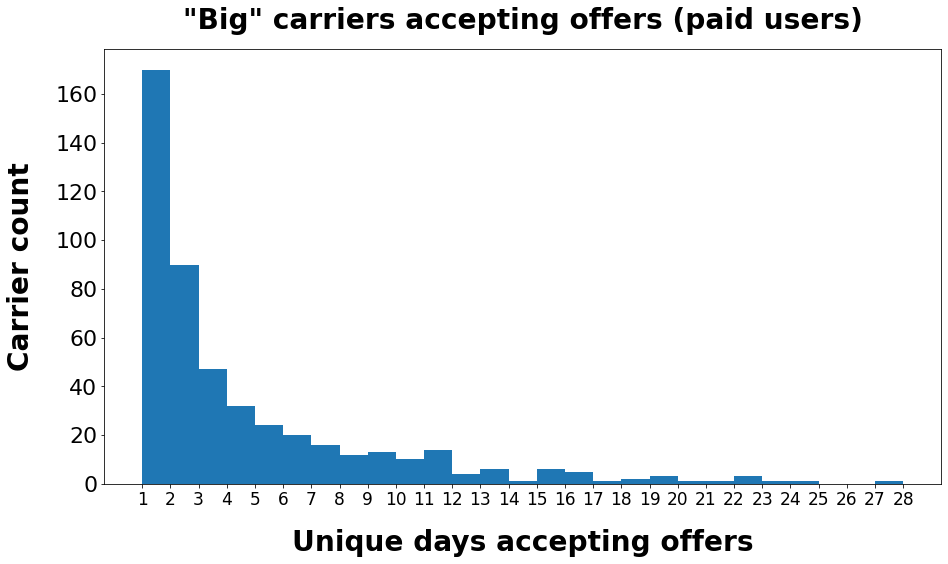

In [17]:
# histogram of unique accepted offers in last 28 days (paid users)
plt.figure(figsize=(15,8))
plt.hist(result_paid_users['unique_days_accepting_offers'], bins=np.arange(1, 29))
plt.xticks(np.arange(1, 29), fontsize=17)
plt.yticks(fontsize=22)
plt.xlabel('Unique days accepting offers', fontsize=28, fontweight='bold', labelpad=20)
plt.ylabel('Carrier count', fontsize=28, fontweight='bold', labelpad=20)
plt.title('"Big" carriers accepting offers (paid users)', fontsize=28, fontweight='bold', pad=20)
plt.show()

# Free users

In [18]:
result_free_users = (result.merge(braintree_with_carriers, how='left', left_on='carrier_guid',
                                           right_on='carrier_guid'))

# Free users will have a missing value under braintree_subscription_status
non_payers = result_free_users['braintree_subscription_status'].isna() == True
# dropping all paid user rows
result_free_users = result_free_users[non_payers]

result_free_users = result_free_users[['carrier_name', 'carrier_guid', 'unique_days_accepting_offers',
                                       'activated_drivers']]
result_free_users['paid_user'] = False
result_free_users

,carrier_name,carrier_guid,unique_days_accepting_offers,activated_drivers,paid_user
0,1 CALL AWAY,d8eeb04e-1f61-4855-9d8c-9fe364dc8044,8,5,False
1,1ST SHOT TRUCKING LLC,fe1298ef-eb41-4557-a1ef-b266e557ac84,2,9,False
2,20 TON CONSTRUCTION LLC,321d9b2c-0b00-41de-9236-e294034610db,1,4,False
3,24 HOUR AUTO TRANSPORT INC,ef52a80c-4eae-4321-b69e-6e47c279ca30,3,3,False
7,2A Transport LLC,21499666-d9a6-4a8f-ad5a-f67da9eb56c5,1,3,False
...,...,...,...,...,...
1443,ats express,6e42a152-66f9-4d5f-b911-790e7ef423e5,4,9,False
1444,d&b transports,4da5ea50-b300-44ba-9424-eb50c54b382e,5,2,False
1446,doyles transportation,6b8d9c0c-d639-4a17-be36-90f37b0e33a9,1,2,False
1447,eco transport,17e62317-e67d-4394-97cb-fcb319d471c3,1,3,False


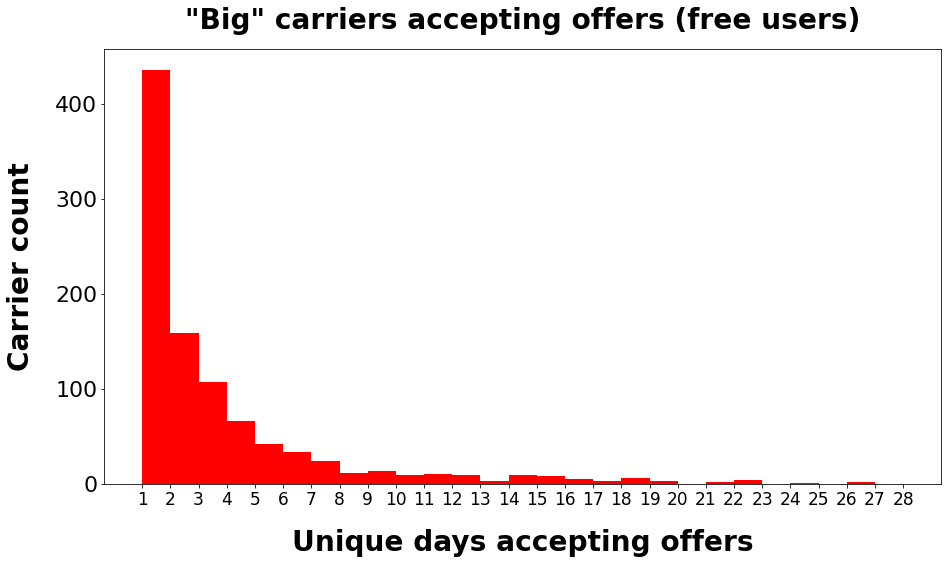

In [19]:
# histogram of unique accepted offers in last 28 days (free users)
plt.figure(figsize=(15,8))
plt.hist(result_free_users['unique_days_accepting_offers'], bins=np.arange(1, 29), color='red')
plt.xticks(np.arange(1, 29), fontsize=17)
plt.yticks(fontsize=22)
plt.xlabel('Unique days accepting offers', fontsize=28, fontweight='bold', labelpad=20)
plt.ylabel('Carrier count', fontsize=28, fontweight='bold', labelpad=20)
plt.title('"Big" carriers accepting offers (free users)', fontsize=28, fontweight='bold', pad=20)
plt.show()

In [20]:
total_paid_carriers_for_days_active = []

for i in range(1,29):
    paid_active_carrier_count = (result_paid_users[result_paid_users['unique_days_accepting_offers'] >= i]
                           .groupby('unique_days_accepting_offers').count()['carrier_guid'].sum())
    
    total_paid_carriers_for_days_active.append(paid_active_carrier_count)
    


total_free_carriers_for_days_active = []

for i in range(1,29):
    free_active_carrier_count = (result_free_users[result_free_users['unique_days_accepting_offers'] >= i]
                           .groupby('unique_days_accepting_offers').count()['carrier_guid'].sum())
    
    total_free_carriers_for_days_active.append(free_active_carrier_count)

In [21]:
paid_active_carriers = pd.DataFrame()
paid_active_carriers['definition_is_this_many_days_active'] = np.arange(1,29)
paid_active_carriers.set_index('definition_is_this_many_days_active', inplace=True)
paid_active_carriers['total_carriers_at_least_this_active'] = total_paid_carriers_for_days_active
paid_active_carriers['total_percentage_active'] = round(100*paid_active_carriers['total_carriers_at_least_this_active']
                                                       /len(result_paid_users))
paid_active_carriers['total_percentage_dormant'] = 100 - paid_active_carriers['total_percentage_active']


free_active_carriers = pd.DataFrame()
free_active_carriers['definition_is_this_many_days_active'] = np.arange(1,29)
free_active_carriers.set_index('definition_is_this_many_days_active', inplace=True)
free_active_carriers['total_carriers_at_least_this_active'] = total_free_carriers_for_days_active
free_active_carriers['total_percentage_active'] = round(100*free_active_carriers['total_carriers_at_least_this_active']
                                                       /len(result_free_users))
free_active_carriers['total_percentage_dormant'] = 100 - free_active_carriers['total_percentage_active']

In [22]:
def paid_vs_non_paid(paid_metric_definition, non_paid_metric_definition):
    plt.figure(figsize=(13,11))
    plt.subplots_adjust(wspace=.9)
    
    plt.subplot(1,2,1)
    paid_graph = sns.barplot(x=['active', 'dormant'],
                        y=[paid_active_carriers.loc[paid_metric_definition, 'total_carriers_at_least_this_active'],
                           (paid_active_carriers.loc[1, 'total_carriers_at_least_this_active'] - 
                            paid_active_carriers.loc[paid_metric_definition, 'total_carriers_at_least_this_active'])],
                        palette='muted')
    for p in paid_graph.patches:
        paid_graph.annotate(p.get_height(), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, -20), 
                       textcoords = 'offset points',
                       fontsize=20)
        paid_graph.annotate('{}%'.format(round(100*p.get_height()/paid_active_carriers.loc[1, 'total_carriers_at_least_this_active'])), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 15), 
                       textcoords = 'offset points',
                       fontsize=20)
    plt.xticks(fontsize=18, fontweight='bold')
    plt.yticks(fontsize=18)
    plt.ylabel('Carrier Count', fontsize=28, fontweight='bold', labelpad=20)
    title = '''If {} out of 28 days
accepted offer
(paid users)'''.format(paid_metric_definition)
    plt.title(title, fontsize=28, fontweight='bold', pad=20)

        
    
    plt.subplot(1,2,2)
    non_paid_graph = sns.barplot(x=['active', 'dormant'],
                        y=[free_active_carriers.loc[non_paid_metric_definition, 'total_carriers_at_least_this_active'],
                           (free_active_carriers.loc[1, 'total_carriers_at_least_this_active'] - 
                            free_active_carriers.loc[non_paid_metric_definition, 'total_carriers_at_least_this_active'])],
                        palette='muted')
    for p in non_paid_graph.patches:
        non_paid_graph.annotate(p.get_height(), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, -20), 
                       textcoords = 'offset points',
                       fontsize=20)
        non_paid_graph.annotate('{}%'.format(round(100*p.get_height()/free_active_carriers.loc[1, 'total_carriers_at_least_this_active'])), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 15), 
                       textcoords = 'offset points',
                       fontsize=20)
    plt.xticks(fontsize=18, fontweight='bold')
    plt.yticks(fontsize=18)
    title = '''If {} out of 28 days
accepted offer
(free users)'''.format(non_paid_metric_definition)
    plt.title(title, fontsize=28, fontweight='bold', pad=20)
    plt.show()

# Metric = unique days 'accepting offers' (carriers with more than 1 driver)
### Our qualitative hypothesis was that a carrier would accept offers 4 out of 28 days.

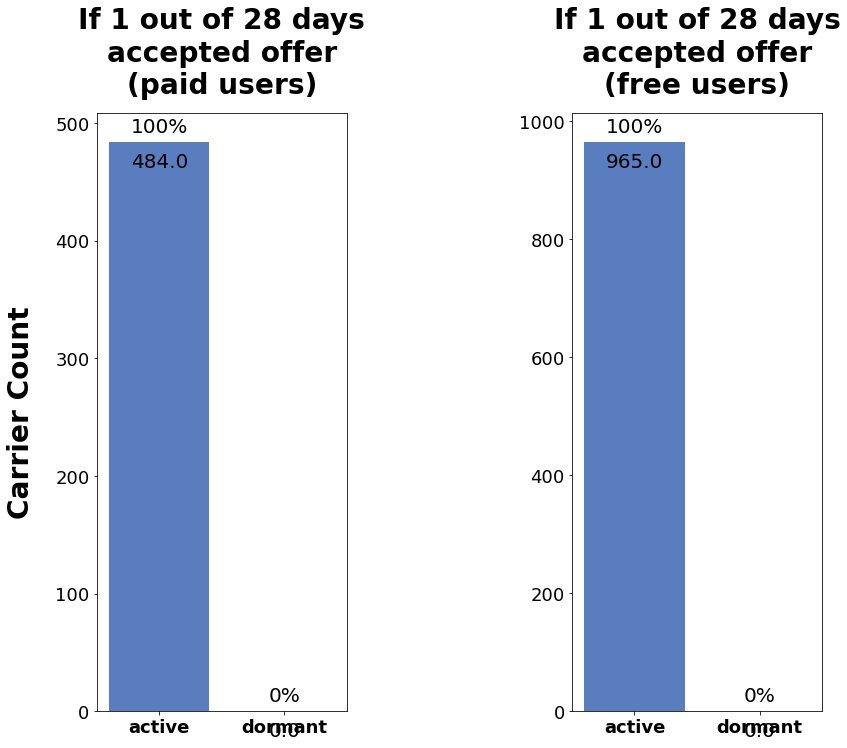

In [30]:
paid_vs_non_paid(1, 1)

## Now let's check percentages "0 frequency" (did not perform metric) users

In [24]:
all_paid_big_carriers = braintree_with_carriers
all_paid_big_carriers = all_paid_big_carriers.merge(active_driver_count,
                                                    left_on=['carrier_guid', 'carrier_id'],
                                                    right_on=['carrier_guid', 'carrier_id'])
# getting only big carriers
all_paid_big_carriers = all_paid_big_carriers[all_paid_big_carriers['activated_drivers'] > 1]
all_paid_big_carriers

,carrier_id,last_sub,braintree_subscription_status,carrier_guid,activated_drivers
0,5466,2016-11-26 09:21:35.868856,Active,101ce8ba-b529-43c1-80bf-c0f6939ba2a3,2
2,4925,2017-01-20 15:19:46.097090,Active,533c4db9-1f0e-4da2-83e1-ed1385508496,11
4,433,2017-06-19 19:32:44.584252,Active,525f3fe2-61bf-452b-b5dd-2ff269a05231,18
5,2634,2016-11-26 09:21:30.293925,Active,61d977bd-62cb-4be7-82b6-54f8a71b4016,2
7,5346,2016-11-26 09:21:35.262542,Active,ace8d77c-fa9a-4cb6-bcb5-569ae3513661,4
...,...,...,...,...,...
2803,25155,2021-01-18 18:54:07.033626,Active,33161d8b-200d-484f-a649-30d32de1638a,43
2804,4116,2021-01-18 20:57:54.743970,Active,ac64fd07-9018-4be7-9c81-fef79f47fbb6,12
2806,36837,2021-01-18 20:43:32.137428,Active,ef227962-d8f0-4a6f-a60f-b9d97c58ceec,21
2807,5659,2021-01-18 21:08:43.603265,Active,a1ef241d-81d3-47c0-91ec-2ce30e79642a,9


In [25]:
all_free_big_carriers =  carriers.merge(braintree_with_carriers, how='left',
                                        left_on='carrier_guid', right_on='carrier_guid')

# getting all free users
non_payers = all_free_big_carriers['braintree_subscription_status'].isna() == True
# #dropping all rows with paid users
all_free_big_carriers = all_free_big_carriers[non_payers]
# getting only big carriers 
all_free_big_carriers = all_free_big_carriers.merge(active_driver_count,
                                                    left_on='carrier_guid',
                                                    right_on='carrier_guid')
all_free_big_carriers = all_free_big_carriers[all_free_big_carriers['activated_drivers'] > 1]
all_free_big_carriers

,name,carrier_id_x,carrier_guid,carrier_id_y,last_sub,braintree_subscription_status,carrier_id,activated_drivers
0,ON DEMAND AUTO TRANSPORT,20,711f7501-69f4-4828-9b78-118db0d15ed9,NaN,NaT,NaN,20,3
1,Jeffries Transport Services,49,c1d94c53-2803-4fe5-b9c9-8df3a0a58670,NaN,NaT,NaN,49,2
16,ROAD WARRIORS,207,529ff481-ba50-45bf-82d2-47f99746f651,NaN,NaT,NaN,207,3
30,Redding Professional Movers LLC,559,17b52472-2156-4f8c-b898-37a9e885d4d9,NaN,NaT,NaN,559,5
40,Kays Automotive Transportation LLC,69,ab79ec93-2e71-484e-9c1d-7a5f8efd7512,NaN,NaT,NaN,69,2
...,...,...,...,...,...,...,...,...
35669,STAR FLEET TRUCKING INC,21858,e4e1df57-3b56-48e4-8610-11125e4efc11,NaN,NaT,NaN,21858,4
35670,BSL TRANSPORT LLC,37443,4eeca8bd-fde2-485d-b967-65e1a8b77b06,NaN,NaT,NaN,37443,2
35672,WILL TRANSPORT LLC,33856,3df83796-57fb-4fbf-8a57-954423cf98d8,NaN,NaT,NaN,33856,2
35674,SMITH AUTO TRANSPORT,32770,e2ddafd8-c53b-463e-ba0c-106056aa9eaa,NaN,NaT,NaN,32770,10


In [26]:
paid_active_carriers = pd.DataFrame()
paid_active_carriers['definition_is_this_many_days_active'] = np.arange(1,29)
paid_active_carriers.set_index('definition_is_this_many_days_active', inplace=True)
paid_active_carriers['total_carriers_at_least_this_active'] = total_paid_carriers_for_days_active
paid_active_carriers['total_dormant_carriers'] = ([len(all_paid_big_carriers) - total_paid_carriers_for_days_active[x]
                                                 for x in range(len(total_paid_carriers_for_days_active))]) 
paid_active_carriers['total_percentage_active'] = round(100*paid_active_carriers['total_carriers_at_least_this_active']
                                                      /len(all_paid_big_carriers))
paid_active_carriers['total_percentage_dormant'] = 100 - paid_active_carriers['total_percentage_active']


free_active_carriers = pd.DataFrame()
free_active_carriers['definition_is_this_many_days_active'] = np.arange(1,29)
free_active_carriers.set_index('definition_is_this_many_days_active', inplace=True)
free_active_carriers['total_carriers_at_least_this_active'] = total_free_carriers_for_days_active
free_active_carriers['total_dormant_carriers'] = ([len(all_free_big_carriers) - total_free_carriers_for_days_active[x]
                                                 for x in range(len(total_free_carriers_for_days_active))])
free_active_carriers['total_percentage_active'] = round(100*free_active_carriers['total_carriers_at_least_this_active']
                                                      /len(all_free_big_carriers))
free_active_carriers['total_percentage_dormant'] = 100 - free_active_carriers['total_percentage_active']

In [27]:
def all_users(paid_metric_definition, free_metric_definition):
    plt.figure(figsize=(13,11))
    plt.subplots_adjust(wspace=.9)
    
    plt.subplot(1,2,1)
    paid_graph = sns.barplot(x=['active', 'dormant'],
                        y=[paid_active_carriers.loc[paid_metric_definition, 'total_carriers_at_least_this_active'],
                           paid_active_carriers.loc[paid_metric_definition, 'total_dormant_carriers']],
                        palette='muted')
    for p in paid_graph.patches:
        paid_graph.annotate(p.get_height(), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, -20), 
                       textcoords = 'offset points',
                       fontsize=20)
        paid_graph.annotate('{}%'.format(round(100*p.get_height()/len(all_paid_big_carriers))), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 15), 
                       textcoords = 'offset points',
                       fontsize=20)
    plt.xticks(fontsize=18, fontweight='bold')
    plt.yticks(fontsize=18)
    plt.ylabel('Carrier Count', fontsize=28, fontweight='bold', labelpad=20)
    title = '''If {} out of 28 days
accepting offer
(paid users)'''.format(paid_metric_definition)
    plt.title(title, fontsize=28, fontweight='bold', pad=20)

        
    
    plt.subplot(1,2,2)
    non_paid_graph = sns.barplot(x=['active', 'dormant'],
                        y=[free_active_carriers.loc[free_metric_definition, 'total_carriers_at_least_this_active'], 
                           free_active_carriers.loc[free_metric_definition, 'total_dormant_carriers']],
                        palette='muted')
    for p in non_paid_graph.patches:
        non_paid_graph.annotate(p.get_height(), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, -20), 
                       textcoords = 'offset points',
                       fontsize=20)
        non_paid_graph.annotate('{}%'.format(round(100*p.get_height()/len(all_free_big_carriers))), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 15), 
                       textcoords = 'offset points',
                       fontsize=20)
    plt.xticks(fontsize=18, fontweight='bold')
    plt.yticks(fontsize=18)
    title = '''If {} out of 28 days
accepting offer
(free users)'''.format(free_metric_definition)
    plt.title(title, fontsize=28, fontweight='bold', pad=20)
    plt.show()

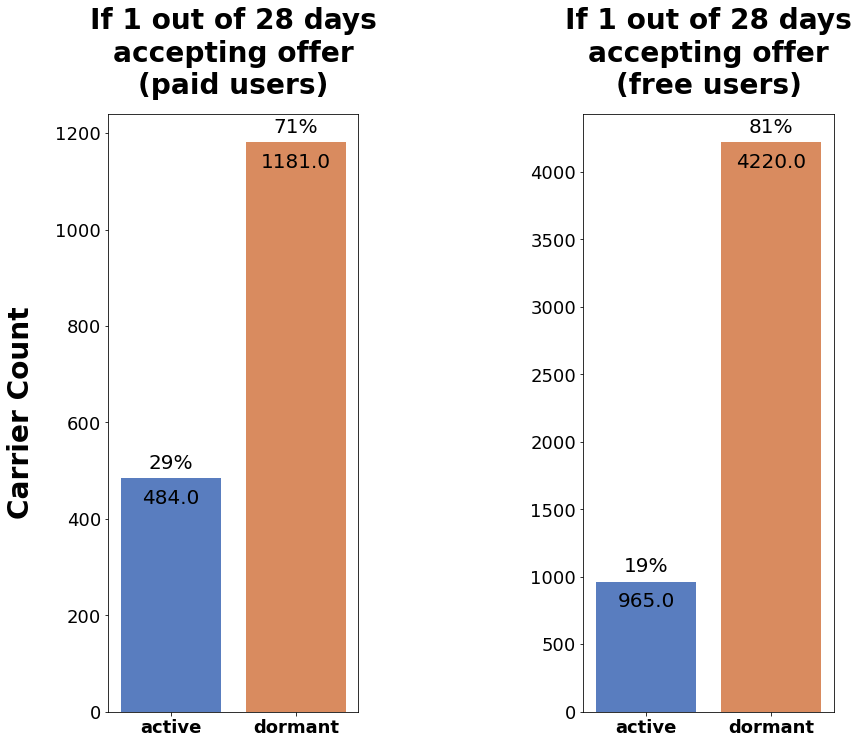

In [28]:
all_users(1,1)